In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
from ggplot import *
import json
import pandas as pd
import numpy as np
import nfldb
from ml.feature_extraction.nfldb_feature_extraction import player_week2dataframe
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def load_preds_and_stats(db, week, year=2015, prefix='predictions', stats = ['receiving_rec', 'receiving_tds', 'receiving_yds', 'rushing_att', 'rushing_tds','rushing_yds'], player_info = ['player_id'], fill_time = False, nonnumeric_cols=['full_name','name_key','opp_team','played','player_id','position','team']):
    # load predictions
    pred_file = ((prefix + '_') if prefix != '' else '') + str(year) + '_' + str(week) + '.json'
    with open(pred_file) as f:
        pred_data = pd.DataFrame(json.load(f))
    
    # load actual stats
    stat_data = player_week2dataframe(db=db, yr_wk=[(year,week)], stats=stats, player_info=player_info, fill_time=fill_time)

    all_data = pd.merge(pred_data, stat_data[player_info + stats], how='left', on='player_id', suffixes=['','_actual'])
    
    for col in [col for col in all_data.columns.values if not col in nonnumeric_cols]:
        all_data[col] = pd.to_numeric(all_data[col])
    
    return all_data

In [3]:
db = nfldb.connect()
weeks = range(8,15)



In [4]:
data = pd.concat([load_preds_and_stats(db=db, week=week) for week in weeks])

In [5]:
stat_template = {
    'receptions':
    {'base1': 'receiving_rec',
     'base2': 'receptions'
    },
    'receiving_yards':
    {'base1': 'receiving_yds',
     'base2': 'rec_yds'
    },
    'receiving_tds':
    {'base1': 'receiving_tds',
    'base2': 'rec_tds'},
    'rush_attempts':
    {'base1': 'rushing_att',
    'base2': 'rush_attempts'},
    'rush_tds':
    {'base1': 'rushing_tds',
    'base2': 'rush_tds'},
    'rush_yards':
    {'base1': 'rushing_yds',
    'base2': 'rush_yds'}
}

In [6]:
stat_dict = {}
for k, v in stat_template.iteritems():
    stat_dict[k] = {
        'actual': v['base1'] + '_actual',
        'historical': v['base1'],
        'expert': 'expert_' + v['base1'],
        'historical_expert': 'hist_expert_' + v['base1'],
        'espn': 'ESPN_' + v['base2'],
        'cbs': 'CBS_' + v['base2'],
        'fftoday': 'FFTODAY_' + v['base2'],
        'nfl': 'NFL_' + v['base2']
    }

In [7]:
def evaluate_prediction(actual, pred, name, fill_na_pred=True, which=None, stat='', rmses={}):
    if(which is None):
        which = pd.notnull(actual)
    
    actual=actual[which]
    pred=pred[which]
        
    
    if(fill_na_pred):
        pred = pred.fillna(0)
    else:
        which_intersect = pd.notnull(actual+pred)
        no_pred = sum(which) - sum(which_intersect)
        pred = pred[which_intersect]
        actual = actual[which_intersect]
    
    abs_errs = np.abs(actual-pred)
    qs = [0,25,50,75,100]
    err_qs = {'q_'+str(q):np.percentile(abs_errs, q=q) for q in qs}
    ret_dict = err_qs
    ret_dict['mae'] = np.mean(abs_errs)
    
    ret_dict['stat'] = stat
    ret_dict['type'] = name
    
    rmse = mean_squared_error(actual, pred)**0.5 if pred.shape[0] > 0 else 0
    rmses.update({name:rmse})
    
    print '   %s - RMSE:%.2f%s' %(name, rmse, '' if fill_na_pred else ' (Could not predict '+str(no_pred)+')')
    
    ret_dict = [{'stat':stat, 'name':name, 'err':err} for err in abs_errs]
    for i in range(len(ret_dict)):
        ret_dict[i]['i'] = i
    
    return(ret_dict)

In [8]:
res_d = []
rmse_list = []
for stat, stat_d in stat_dict.iteritems():
    actual = data[stat_d['actual']]
    #which = pd.notnull(actual)
    which = pd.notnull(data[stat_d['actual']] + actual)
    
    fill_na_pred = True
    
    print '-'*50
    print '%s (n=%.0f):' %(stat, sum(which))
    
    rmses = {'stat': stat}
    
    res_d.extend(evaluate_prediction(actual, data[stat_d['historical']], 'Historical', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    res_d.extend(evaluate_prediction(actual, data[stat_d['expert']], 'Expert', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    res_d.extend(evaluate_prediction(actual, data[stat_d['historical_expert']], 'HistoricalAndExpert', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    res_d.extend(evaluate_prediction(actual, data[stat_d['espn']], 'ESPN', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    res_d.extend(evaluate_prediction(actual, data[stat_d['cbs']], 'CBS', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    res_d.extend(evaluate_prediction(actual, data[stat_d['fftoday']], 'FFToday', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    #evaluate_prediction(actual, data[stat_d['nfl']], 'NFL', fill_na_pred=fill_na_pred, which=which)
    
    res_d.extend(evaluate_prediction(actual, actual.replace(to_replace=actual, value=np.mean(actual)), 'Baseline', fill_na_pred=fill_na_pred, which=which, stat=stat, rmses=rmses))
    
    rmse_list.append(rmses)

--------------------------------------------------
receptions (n=560):
   Historical - RMSE:1.59
   Expert - RMSE:1.71
   HistoricalAndExpert - RMSE:1.73
   ESPN - RMSE:1.67
   CBS - RMSE:1.60
   FFToday - RMSE:1.72
   Baseline - RMSE:1.92
--------------------------------------------------
receiving_tds (n=560):
   Historical - RMSE:0.24
   Expert - RMSE:0.31
   HistoricalAndExpert - RMSE:0.31
   ESPN - RMSE:0.26
   CBS - RMSE:0.26
   FFToday - RMSE:0.29
   Baseline - RMSE:0.26
--------------------------------------------------
rush_tds (n=560):
   Historical - RMSE:0.40
   Expert - RMSE:0.47
   HistoricalAndExpert - RMSE:0.46
   ESPN - RMSE:0.42
   CBS - RMSE:0.42
   FFToday - RMSE:0.51
   Baseline - RMSE:0.43
--------------------------------------------------
receiving_yards (n=560):
   Historical - RMSE:17.89
   Expert - RMSE:19.35
   HistoricalAndExpert - RMSE:19.44
   ESPN - RMSE:19.01
   CBS - RMSE:18.95
   FFToday - RMSE:18.55
   Baseline - RMSE:20.81
---------------------------

In [22]:
rmse_transpose = []
for name in rmse_list[0]:
    if name != 'stat':
        di = {d['stat']:d[name] for d in rmse_list}
        di.update({'type':name})
        rmse_transpose.append(di)
    

In [24]:
rmse_file = 'rmse_%.0f_%.0f.json' % (weeks[0], weeks[-1])
with open(rmse_file, 'w+') as f:
        json.dump(rmse_transpose, f)

In [25]:
res_df = pd.DataFrame(res_d)
res_df = res_df.pivot_table(index=['stat','i'], columns=['name'], values='err')

In [26]:
color = dict(boxes='Black', whiskers='Black',medians='Blue', caps='Black')
save_path = 'result_boxplots'

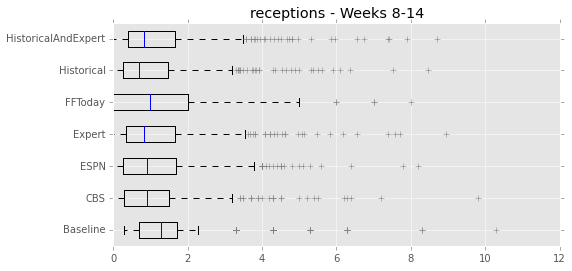

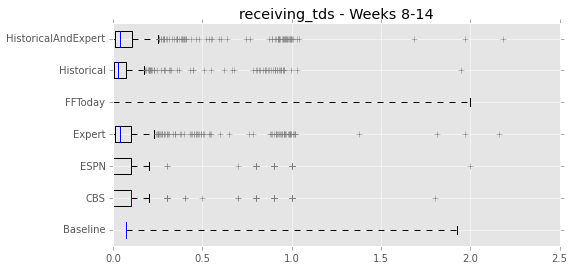

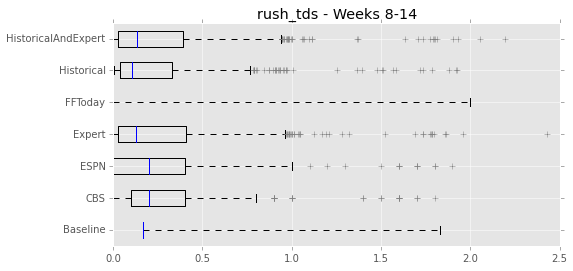

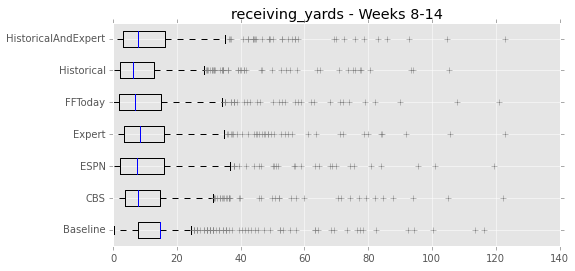

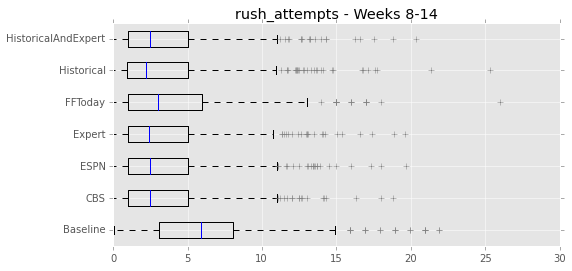

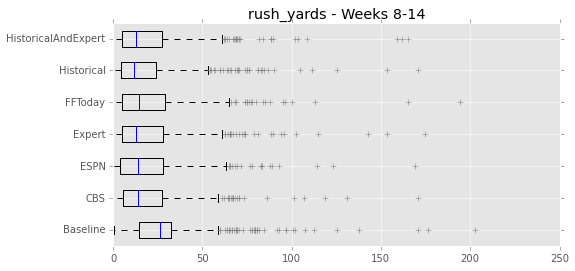

In [27]:
for stat in stat_template.keys():
    res_ax = res_df.loc[stat,:].plot(figsize=(8, 4), kind='box', vert=False, color=color, sym='grey', title=('%s - Weeks %.0f-%.0f') %(stat, weeks[0], weeks[-1]))
    file_name = ('%s/%s_%.0f_%.0f.png') %(save_path, stat, weeks[0], weeks[-1])
    fig = res_ax.get_figure()
    fig.savefig(file_name, bbox_inches='tight')